# RETO MINSAIT REAL STATE MODELLING

## <span style="color:#63A884"> FRP Learning </span>

### <span style="color:#8AA0AE">Aitor Mira Abad</span>
### <span style="color:#8AA0AE">Fermín Leal Payá</span>

### Fecha: 2019-03-15

# ÍNDICE
## 1. Tratamiento de Imágenes
### 1.1 Carga y Extracción de Datos de Imágenes
### 1.2 Reducción de Dimensión
## 2. Tratamiento de Datos
### 2.1 Carga de Datos
### 2.2 Feature Engineering
### 2.3 NLP
### 2.4 Feature Interactions
### 2.5 Target Engineering
#### 2.5.1 Linealización del Target
#### 2.5.2 Target Anómalos
## 3. Modelling
### 3.1 Preparación de Datos
### 3.2 Definición de Modelos
### 3.3 Entrenamiento y Validación
## 4.  Predicción y Entrega
## ANEXO I. Optimización.
### AI.1 Búsqueda de Parámetros Óptimos
### AI.2 Percentil Óptimo
### AI.3 NLP

# 1. TRATAMIENTO DE IMÁGENES

## 1.1 Carga y Extracción de Datos de Imágenes

El primer paso a dar en el presente reto es el procesado de imágenes. Con el objetivo de tratarlas más adelante junto a los datos de entrenamiento, vamos a obtener la siguiente información:

1. NOMBRE
2. ALTURA
3. ANCHURA
4. HISTOGRAMA EN RGB
5. HISTOGRAMA EN GREYSCALE
6. IMAGEN EN RGB (FLAT ARRAY)
7. IMAGEN EN GRAYSCALE (FLAT ARRAY)
8. NUMERO DE IMAGENES POR INMUEBLE

In [ ]:
#Como paso previo a cualquier proceso, se cargan todas las librerías necesarias para el tratamiento de imágenes
from PIL import Image
import os
import numpy as np
import pickle
import re

import pandas as pd
from PIL import Image
import os
import numpy as np
import pickle
import re

import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

En este paso se cargarán todas las imágenes y crear una lista de diccionarios que contengan la información que queremos extraer. Las imágenes serán transformadas a 50x50 para poder tratarlas más rápidamente, ya que si no el tiempo de cómputo sería inasumible. Otra de las tareas a realizar es limpiar el nombre de las imágenes, para conservar simplemente el identificador de las mismas y así puedan ser cruzadas con los datos posteriormente. Una vez extraída la información y el diccionario creado, se almacenará con la librería pickle de serialización de archivos.

In [ ]:
#En primer lugar se extrae la información contenida en las imágenes

#Cargar imagenes
PATH_TO_IMAGES = '../Datos/Imagenes/'
image_paths = os.listdir(PATH_TO_IMAGES)
print(image_paths)

#Crear lista de imagenes
list_of_image_data = []


for im in image_paths:
	try:
		imag = PATH_TO_IMAGES + im
		image = Image.open(imag)
        #Convertir a monocroma
		image_grey = image.convert('1')
		hist_g = image_grey.histogram()
		width, height = image.size
		hist = image.histogram()
        #transformar la imagen a 50x50
		im = image.resize((50,50),Image.BICUBIC)
		arr = np.array(im)
		flat_arr = arr.ravel()
		im_g= image_grey.resize((50,50),Image.BICUBIC)
		arr_g = np.array(im_g)
		flat_arr_g = arr_g.ravel()
        #Extraer nombres
		aux=re.search(r"[^/]+$",imag)
		aux2=aux.group(0)
		aux3=re.search(r"[^_]*", aux2)
		ids=aux3.group(0)
		aux4=re.search(r"(?<=_)(.*)(?=_)", aux2)
		aux5=aux4.group(0)
		num=re.search(r"[0-9](.*)(?=_)", aux5)
		num2=num.group(0)
		final_name=ids+'_'+num2
        #Crear diccionario por imagen
		imdict = {
	    'name': final_name,
	    'height': height,
	    'width': width,
		'hist': hist,
		'hist_g': hist_g,
		'image3': flat_arr,
		'image1': flat_arr_g
	    }

		print(final_name,height,width)
        #añadir dictcionario de cada imagen a lista
		list_of_image_data.append(imdict)
	except Exception as e: print(e); continue


#guardar lista de diccionarios
with open('list_images.pickle', 'wb') as handle:
	pickle.dump(list_of_image_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#Tras esto se limpian variables y ram tras el intensivo proceso de carga de imágenes
%reset -f

Esta lista de diccionarios se debe transformar a un formato que permita cruzarlo con los datos. Se ha elegido un DataFrame Pandas como estandar en tratamiento de datos. Para esto se creará una matriz que será transformada a pd.DataFrame y lo será almacenada en un CSV con el nombre de archivo 'df_imagenes.csv'.

In [ ]:
# A continuación, se procede a convertir la lista de diccionarios a un dataset para cargarlo en Pandas como DataFrame
print('Cargando Imagenes...')
with open("list_images.pickle", "rb") as f:
    images = pickle.load(f)

columns_image=list(range(11024))
columns_image.append('NAME')
columns_image.append('NUMERO_IMS')
columns_image.append('HEIGHT')
columns_image.append('WIDTH')


lst=[]
for i in images:
    name=re.search(r"[^_]*",i['name']).group(0)
    num=re.search(r"(?<=_).*$", i['name']).group(0)
    height=i['height']
    width=i['width']
    aux=i['image3'].tolist()
    aux_2=i['image1'].tolist()
    hist=i['hist']
    hist_g =i['hist_g']
    #print(len(aux),len(aux_2),len(hist),len(hist_g))
    aux.extend(aux_2)
    aux.extend(hist)
    aux.extend(hist_g)
    aux.append(name)
    aux.append(num)
    aux.append(height)
    aux.append(width)
    lst.append(aux)
    print(name,num)
    #break

print('Guardando dataset...')
pd.DataFrame(lst,columns=columns_image).to_csv('df_images.csv',sep='|')

In [ ]:
#Tras esto se limpian variables y ram tras el intensivo proceso de carga de imágenes
%reset -f

In [ ]:
#Finalmente, se carga directmente el dataset de imágenes generado
df = pd.read_csv('df_images.csv',index_col=0,sep='|',low_memory=False)
df.head()

In [ ]:
#Se han identificado fotos que solo tienen un canal. Se corresponden con planos del inmueble. Se eliminan.
lista_conv = ['NAME','NUMERO_IMS','HEIGHT','WIDTH']
df=df[~df.NAME.isnull()]
for i in lista_conv:
    df[i] =df[i].astype(int)

El siguiente código tiene como finalidad contar las imágenes correspondientes a cada observación. De esta se conocerá cuantas imágenes tiene cada anuncio analizado, lo que puede aportar gran cantidad de información al modelo. Un usuario que entra con intención de comprar un inmueble, evidentemente requiere ver fotos del mismo, y la cantidad de fotos puede ser decisiva para determinar el tiempo que pase en la página del anuncio.

In [ ]:
#Se hace un recuento de imágenes por cada inmueble
count_pics=pd.DataFrame(df.groupby('NAME')['NAME'].count())
count_pics.rename(columns={'NAME':'COUNT'},inplace='True')
count_pics['NAME']=count_pics.index
count_pics.head()

In [ ]:
#Se agrega el recuento de imágenes al dataset de imágenes
df_final=df.merge(count_pics, on='NAME',how='left')
df_final.head()

In [ ]:
#Por último, se guarda el dataset final con todo el tratamiento de imágenes
df_final.to_csv('images_join.csv', sep='|', encoding='utf8')

In [ ]:
#Tras esto se limpian variables y ram tras el intensivo proceso de carga de imágenes
%reset -f

## 1.2 Reducción de Dimensión
Se procede conversión final para poder juntar los datos con el dataset de entrenamiento de forma eficiente mediante la técnica de reducción dimensional PCA.

In [ ]:
#Se separa el dataset por tipo de datos (rgb,monocroma,rgb,etc...)
df=pd.read_csv('images_join.csv', sep ='|',index_col = 0,encoding='utf8')
df_rgb=df.loc[:, '0':'7499']
df_monocroma=df.loc[:, '7500':'9999']
df_hist_rgb=df.loc[:, '10000':'10767']
df_hist_mono=df.loc[:, '10768':'11023']
nombres=df.loc[:, 'NAME':'COUNT']

In [ ]:
#Se escala y extrae un PCA de cada componente
pca = PCA(n_components=12)

sc=StandardScaler()
sc_rgb=sc.fit(df_rgb)
df_rgb_t=sc_rgb.transform(df_rgb)

sc_mono=sc.fit(df_monocroma)
df_mono_t=sc_mono.transform(df_monocroma)

sc_hist_rgb=sc.fit(df_hist_rgb)
df_hist_rgb_t=sc_hist_rgb.transform(df_hist_rgb)

sc_hist_mono=sc.fit(df_hist_mono)
df_hist_mono_t=sc_hist_mono.transform(df_hist_mono)

images_rgb = pca.fit_transform(df_rgb_t)
images_mono = pca.fit_transform(df_mono_t)
hist_rgb = pca.fit_transform(df_hist_rgb_t)
hist_mono = pca.fit_transform(df_hist_mono_t)

In [ ]:
#Se concatenan todos los datasets obtenidos
df_im=pd.concat([nombres,pd.DataFrame(images_rgb),pd.DataFrame(images_mono),pd.DataFrame(hist_rgb),pd.DataFrame(hist_mono)],axis=1)

In [ ]:
#Se renombran las columnas PCA
df_im.columns=['NAME','NUMERO_IMS','HEIGHT','WIDTH','COUNT',\
               0,1,2,3,4,5,6,7,8,9,10,11,\
               00,11,22,33,44,55,66,77,88,99,1010,1111,\
               000,111,222,333,444,555,666,777,888,999,101010,111111,\
               0000,1111,2222,3333,4444,5555,6666,7777,8888,9999,10101010,11111111]

In [ ]:
#Se eliminan las columnas del monocroma que no contienen información relevante
df_im.drop([3333,4444,5555,6666,7777,8888,9999,10101010,11111111],axis=1,inplace=True)

In [ ]:
#Se guarda el dataset final listo para ser añadido al dataset principal del reto
df_im.to_csv('../Datos/Modelar/images_join_PCA.csv', sep='|', encoding='utf8')

In [ ]:
#Tras esto se limpian variables y ram tras el intensivo proceso de tratamiento de imágenes
%reset -f

# 2. TRATAMIENTO DE DATOS

In [1]:
# En primer lugar se importan los paquetes necesarios para el proceso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import linear_model
from sklearn.metrics import median_absolute_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import scale
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from stop_words import get_stop_words
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import chi2, SelectKBest
import warnings

# Adicionalmente configuramos Pandas para mostrar todas las filas y columnas al inspeccionar un DataFrame
pd.options.display.max_columns=None
pd.options.display.max_rows=None

#Por último se configura el sistema de advertencias para que sean ignoradas
warnings.filterwarnings("ignore")

## 2.1 Carga de Datos

En este apartado procedemos con la limpieza y procesamiento del dataset "Modelar_UH2019.txt" para poder entrenar el modelo, así como el "Estimar_UH2019.txt" para su predicción.

In [2]:
#Definimos diccionarios para cargar variables con su tipo. Uno para el Dataset de Modelado y otro para Estimación.

datatype = {'HY_id':int, 'HY_tipo':str, 'HY_cod_postal':int, 'HY_provincia':str, 'HY_descripcion':str, 
'HY_distribucion': str, 'HY_antiguedad': float, 'HY_metros_utiles': float, 'HY_metros_totales': float, 
'HY_num_banos': int, 'HY_cert_energ': str, 'HY_num_terrazas': int, 'HY_ascensor': int, 'HY_trastero': int,
'HY_num_garajes': int, 'HY_precio': float, 'HY_precio_anterior': float, 'IDEA_area': float, 'IDEA_poblacion': float,
'IDEA_densidad': float, 'IDEA_pc_1960': float, 'IDEA_pc_1960_69': float, 'IDEA_pc_1970_79': float, 
'IDEA_pc_1980_89': float, 'IDEA_pc_1990_99': float, 'IDEA_pc_2000_10': float, 'IDEA_pc_comercio': float,
'IDEA_pc_industria': float, 'IDEA_pc_oficina': float, 'IDEA_pc_otros': float, 'IDEA_pc_residencial': float,
'IDEA_pc_trast_parking': float, 'IDEA_ind_tienda': float, 'IDEA_ind_turismo': float, 'IDEA_ind_alimentacion': float,
'IDEA_ind_riqueza': float, 'IDEA_rent_alquiler': float, 'IDEA_ind_elasticidad': float, 'IDEA_ind_liquidez': float,
'IDEA_unitprice_sale_residential': float, 'IDEA_price_sale_residential': float, 'IDEA_stock_sale_residential': float,
'IDEA_demand_sale_residential': float, 'IDEA_unitprice_rent_residential': float, 
'IDEA_price_rent_residential': float, 'IDEA_stock_rent_residential': float, 'IDEA_demand_rent_residential': float,
'GA_page_views': int, 'GA_bounce_rate':float, 'GA_exit_rate': float, 'GA_quincena_ini': int, 'GA_quincena_ult': int,
'TARGET': float}

datatype_test = {'HY_id':int, 'HY_tipo':str, 'HY_cod_postal':int, 'HY_provincia':str, 'HY_descripcion':str, 
'HY_distribucion': str, 'HY_antiguedad': float, 'HY_metros_utiles': float, 'HY_metros_totales': float, 
'HY_num_banos': int, 'HY_cert_energ': str, 'HY_num_terrazas': int, 'HY_ascensor': int, 'HY_trastero': int,
'HY_num_garajes': int, 'HY_precio': float, 'HY_precio_anterior': float, 'IDEA_area': float, 'IDEA_poblacion': float,
'IDEA_densidad': float, 'IDEA_pc_1960': float, 'IDEA_pc_1960_69': float, 'IDEA_pc_1970_79': float, 
'IDEA_pc_1980_89': float, 'IDEA_pc_1990_99': float, 'IDEA_pc_2000_10': float, 'IDEA_pc_comercio': float,
'IDEA_pc_industria': float, 'IDEA_pc_oficina': float, 'IDEA_pc_otros': float, 'IDEA_pc_residencial': float,
'IDEA_pc_trast_parking': float, 'IDEA_ind_tienda': float, 'IDEA_ind_turismo': float, 'IDEA_ind_alimentacion': float,
'IDEA_ind_riqueza': float, 'IDEA_rent_alquiler': float, 'IDEA_ind_elasticidad': float, 'IDEA_ind_liquidez': float,
'IDEA_unitprice_sale_residential': float, 'IDEA_price_sale_residential': float, 'IDEA_stock_sale_residential': float,
'IDEA_demand_sale_residential': float, 'IDEA_unitprice_rent_residential': float, 
'IDEA_price_rent_residential': float, 'IDEA_stock_rent_residential': float, 'IDEA_demand_rent_residential': float,
'GA_page_views': int, 'GA_bounce_rate':float, 'GA_exit_rate': float, 'GA_quincena_ini': int, 'GA_quincena_ult': int}


#Se procede a cagar datasets a los cuales se añade la columna "ESTIMAR" que identificará los registos de cada dataset
df_ini = pd.read_csv('../Datos/Modelar/Modelar_UH2019.txt', sep = '|', dtype = datatype, low_memory = False)
df_ini['ESTIMAR'] =0
df_test = pd.read_csv('../Datos/Estimar/Estimar_UH2019.txt', sep = '|', dtype = datatype_test, low_memory = False)
df_test['ESTIMAR'] = 1

#Con el objetivo de concatenar los datasets se crea la columna "TARGET" en el dataset de estimación con un valor dummy
df_test['TARGET'] = 99999999999

#La concatenación de ambos datasets respeta el orden de las observaciones pero los reindexa para evitar errores en el procesado
df_ini = pd.concat([df_ini,df_test],sort=False,ignore_index=True)

In [3]:
# En una primera inspección de los 5 primeros valores se comprueba visualmente que el proceso de carga es correcto
df_ini.head()

,HY_id,HY_cod_postal,HY_provincia,HY_descripcion,HY_distribucion,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,HY_cert_energ,HY_num_terrazas,HY_ascensor,HY_trastero,HY_num_garajes,HY_precio,HY_precio_anterior,IDEA_area,IDEA_poblacion,IDEA_densidad,IDEA_pc_1960,IDEA_pc_1960_69,IDEA_pc_1970_79,IDEA_pc_1980_89,IDEA_pc_1990_99,IDEA_pc_2000_10,IDEA_pc_comercio,IDEA_pc_industria,IDEA_pc_oficina,IDEA_pc_otros,IDEA_pc_residencial,IDEA_pc_trast_parking,IDEA_ind_tienda,IDEA_ind_turismo,IDEA_ind_alimentacion,IDEA_ind_riqueza,IDEA_rent_alquiler,IDEA_ind_elasticidad,IDEA_ind_liquidez,IDEA_unitprice_sale_residential,IDEA_price_sale_residential,IDEA_stock_sale_residential,IDEA_demand_sale_residential,IDEA_unitprice_rent_residential,IDEA_price_rent_residential,IDEA_stock_rent_residential,IDEA_demand_rent_residential,GA_page_views,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET,ESTIMAR
0,6028499,18151,Granada,Plaza de Garaje ubicada en la planta sótano de...,NaN,Garaje,NaN,NaN,35.00,0,NaN,0,0,0,0,12300.0,NaN,670.87,13372.0,19.93,0.00,0.00,0.00,0.27,0.31,0.41,0.01,0.00,0.0,0.10,0.55,0.34,0.20,0.60,0.20,0.20,4.21,2.0,1.0,1043.31,163841.89,3417.0,48.34,5.09,626.38,237.0,51.01,71,7.14,10.65,2,46,32.16,0
1,6028500,29915,Málaga,NaN,NaN,Casa de pueblo,NaN,NaN,151.98,2,NaN,0,0,0,0,115000.0,125000.0,2216.24,1507.0,0.68,0.12,0.12,0.18,0.18,0.18,0.22,0.02,0.00,0.0,0.06,0.57,0.35,0.00,0.00,0.00,0.17,NaN,NaN,NaN,708.18,121250.00,33.0,0.00,4.08,700.00,6.0,50.69,684,16.36,5.25,1,47,30.71,0
2,6028502,3740,Alicante,El inmueble(piso) se encuentra situado en el d...,VIVIENDA-PISO,Piso,2008.0,92.58,102.78,1,NaN,0,1,0,1,88000.0,93500.0,2040.53,5810.0,2.85,0.15,0.15,0.12,0.10,0.11,0.36,0.03,0.05,0.0,0.17,0.59,0.17,0.76,0.08,0.15,0.16,6.52,NaN,NaN,1080.75,144013.80,393.0,49.51,4.43,525.00,15.0,51.82,651,15.12,11.21,1,47,63.48,0
3,6028512,30592,Murcia,Plaza de garaje situada en la planta semisótan...,NaN,Garaje,NaN,11.81,12.46,0,NaN,0,1,0,0,5800.0,NaN,905.44,7004.0,7.74,0.07,0.07,0.04,0.04,0.17,0.62,0.01,0.01,0.0,0.06,0.45,0.47,0.51,0.06,0.43,0.31,4.39,NaN,NaN,1133.81,229375.00,654.0,49.95,5.03,863.17,168.0,50.74,92,15.82,14.55,2,47,108.27,0
4,6028513,30592,Murcia,Plaza de garaje situada en la planta semisótan...,NaN,Garaje,NaN,14.29,15.43,0,NaN,0,1,0,0,7400.0,NaN,905.44,7004.0,7.74,0.07,0.07,0.04,0.04,0.17,0.62,0.01,0.01,0.0,0.06,0.45,0.47,0.51,0.06,0.43,0.31,4.39,NaN,NaN,1133.81,229375.00,654.0,49.95,5.03,863.17,168.0,50.74,3,0.00,0.00,2,39,7.50,0


In [4]:
# Se comprueban adicionalmente los últimos 5 valores
df_ini.tail()

,HY_id,HY_cod_postal,HY_provincia,HY_descripcion,HY_distribucion,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,HY_cert_energ,HY_num_terrazas,HY_ascensor,HY_trastero,HY_num_garajes,HY_precio,HY_precio_anterior,IDEA_area,IDEA_poblacion,IDEA_densidad,IDEA_pc_1960,IDEA_pc_1960_69,IDEA_pc_1970_79,IDEA_pc_1980_89,IDEA_pc_1990_99,IDEA_pc_2000_10,IDEA_pc_comercio,IDEA_pc_industria,IDEA_pc_oficina,IDEA_pc_otros,IDEA_pc_residencial,IDEA_pc_trast_parking,IDEA_ind_tienda,IDEA_ind_turismo,IDEA_ind_alimentacion,IDEA_ind_riqueza,IDEA_rent_alquiler,IDEA_ind_elasticidad,IDEA_ind_liquidez,IDEA_unitprice_sale_residential,IDEA_price_sale_residential,IDEA_stock_sale_residential,IDEA_demand_sale_residential,IDEA_unitprice_rent_residential,IDEA_price_rent_residential,IDEA_stock_rent_residential,IDEA_demand_rent_residential,GA_page_views,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET,ESTIMAR
11057,7008542,46400,Valencia,NaN,NaN,Piso,NaN,72.82,83.21,2,NaN,0,0,0,0,72300.0,NaN,743.27,10755.0,14.47,0.28,0.28,0.18,0.10,0.05,0.10,0.02,0.01,0.01,0.02,0.58,0.37,0.47,0.42,0.11,0.13,5.10,5.0,0.0,877.64,123177.71,1329.0,49.83,5.77,543.00,144.0,52.12,18,41.67,52.50,41,46,1.000000e+11,1
11058,7009969,4600,Almería,NaN,NaN,Casa de pueblo,NaN,90.56,100.00,1,NaN,0,0,0,0,85500.0,NaN,31685.54,16922.0,0.53,0.11,0.11,0.10,0.16,0.14,0.37,0.02,0.00,0.00,0.07,0.52,0.38,0.51,0.21,0.28,0.13,4.15,3.0,0.0,823.22,115127.06,783.0,48.09,3.21,447.69,18.0,52.20,3,0.00,25.00,43,46,1.000000e+11,1
11059,7006642,30540,Murcia,NaN,NaN,Piso,NaN,89.40,116.12,0,NaN,0,0,0,0,91700.0,NaN,8752.14,6478.0,0.74,0.24,0.24,0.13,0.12,0.09,0.18,0.02,0.03,0.00,0.09,0.47,0.39,0.31,0.62,0.08,0.10,7.23,NaN,NaN,644.70,81900.87,273.0,48.12,2.43,400.00,6.0,0.00,51,23.33,15.97,41,47,1.000000e+11,1
11060,7006630,29680,Málaga,NaN,NaN,Piso,NaN,98.29,124.13,0,NaN,0,0,0,0,171000.0,NaN,212.16,9502.0,44.79,0.01,0.01,0.20,0.15,0.18,0.46,0.05,0.04,0.00,0.13,0.41,0.37,0.50,0.00,0.50,0.31,3.13,NaN,NaN,1684.35,279668.89,1182.0,48.71,7.52,906.25,111.0,51.11,34,10.23,31.84,39,46,1.000000e+11,1
11061,7007777,46910,Valencia,NaN,NaN,Piso,NaN,90.00,119.00,2,NaN,0,0,0,1,138000.0,NaN,974.79,19215.0,19.71,0.08,0.08,0.39,0.08,0.14,0.22,0.03,0.01,0.02,0.02,0.55,0.36,0.67,0.15,0.17,0.13,5.41,2.5,1.0,1040.90,173326.47,2346.0,49.31,4.69,675.58,141.0,52.23,12,72.22,54.44,41,44,1.000000e+11,1


In [5]:
#Obtenido el DataFrame de los datasets, se ejecuta la carga del dataset de imagenes previamente procesadas
df_img = pd.read_csv('../Datos/Modelar/images_join_PCA.csv', sep ='|',index_col = 0,encoding='utf8')

El tratamiento de las imágenes ha generado una gran cantidad de información a utilizar para el problema de regresión. Se ha utilizado un proceso lógico de prueba-error iterativo en el que se ha comprobado la cantidad y calidad de información que aportaban todas estas variables al modelo analizando los distintos outputs en que ha resultado. Tras su estudio en detalle se ha encontrado una relación clara con la información de las siguientes columnas:

1. NAME
2. HEIGHT
3. WITH
4. COUNT

Estas columnas, que se corresponden con los metadatos de las imágenes, han conseguido mejorar considerablemente la regresión del modelo mientras que el resto de datos, referentes al contenido de las imágenes, no han arrojado ningún tipo de mejora sobre el modelo.

Para verificar que el contenido de las imágenes realmente no estubieran aportando ninguna mejora al modelo, se ha preparado una clusterización de imágenes mediante un modelo K-MEANS con un número de clústers óptimo. Esta agrupación de imágenes por su contenido habría aportado información en el caso de existir una fuerte relación, en cambio esta metodología tampoco ha conseguido mejorar la regresión.

In [6]:
#Se seleccionan las columnas que mejor resultado generan
df_img=df_img[['NAME','HEIGHT','WIDTH','COUNT']]

In [7]:
#Dado que puede existir más de una imágen por registro, estas se agrupan y promedian
df_img=df_img.groupby('NAME', as_index=False).mean()

In [8]:
#Finalmente, se ejecuta una unión de datasets para agregar la información de las imágenes al dataset principal
df_ini=df_ini.merge(df_img, left_on = 'HY_id', right_on= 'NAME', how ='left')

## 2.2 Features Engineering

En este apartado se tratarán los datos de forma oportuna según los requisitos de entrada de los modelos de análisis y de forma que aporten la mayor información posible al propio modelo.

In [9]:
#Inspeccionamos en primer lugar las columnas del DataFrame
df_ini.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11062 entries, 0 to 11061
Data columns (total 58 columns):
HY_id                              11062 non-null int32
HY_cod_postal                      11062 non-null int32
HY_provincia                       11018 non-null object
HY_descripcion                     6675 non-null object
HY_distribucion                    3545 non-null object
HY_tipo                            11062 non-null object
HY_antiguedad                      4971 non-null float64
HY_metros_utiles                   7850 non-null float64
HY_metros_totales                  11025 non-null float64
HY_num_banos                       11062 non-null int32
HY_cert_energ                      1842 non-null object
HY_num_terrazas                    11062 non-null int32
HY_ascensor                        11062 non-null int32
HY_trastero                        11062 non-null int32
HY_num_garajes                     11062 non-null int32
HY_precio                          11062 non-

En primer lugar se tratarán las columnas cuya información es de tipo categórico. Estas columnas tienen valores numéricos o de texto que requerirán un tratamiento para que el modelo pueda interpretar la información. Para las columnas caracterizadas con valores únicos, se ha realizado una transformación de esos valores en códigos. Está transformación permite obtener en una misma columna un código numérico para cada una de las categorías de la columna.

Se ha optado por esta aproximación al problema ya que el tratamiento categórico, con una posterior transformación en columnas dummies afectaba negativamente al modelo obteniendo un error mayor.

Las variables de texto libre se tratarán posteriormente.

In [10]:
#Generamos codigos de las columnas con información categórica
df_ini['HY_cod_postal']=df_ini.HY_cod_postal.astype('str').astype('category').cat.codes
df_ini['HY_provincia'] =df_ini.HY_provincia.astype('category').cat.codes
df_ini['HY_tipo']=df_ini.HY_tipo.astype('str').astype('category').cat.codes
df_ini['HY_antiguedad']=df_ini.HY_antiguedad.astype('str').astype('category').cat.codes
df_ini['HY_num_banos']=df_ini.HY_num_banos.astype('str').astype('category').cat.codes
df_ini['HY_num_terrazas']=df_ini.HY_num_terrazas.astype('str').astype('category').cat.codes
df_ini['HY_ascensor']=df_ini.HY_ascensor.astype('str').astype('category').cat.codes
df_ini['HY_trastero']=df_ini.HY_trastero.astype('str').astype('category').cat.codes
df_ini['HY_num_garajes']=df_ini.HY_num_garajes.astype('str').astype('category').cat.codes

#Antes generar códigos para la columna de certificación energética se rellenarán los nulos con un valor dummy
df_ini.HY_cert_energ.fillna('Z',inplace=True)
df_ini['HY_cert_energ']=df_ini.HY_cert_energ.astype('str').astype('category').cat.codes

In [11]:
#Se rellenan los datos faltantes con lógica para cada columna
df_ini['HY_metros_totales'].fillna(df_ini['HY_metros_totales'].median(),inplace=True)
df_ini['HY_metros_utiles'].fillna(df_ini['HY_metros_totales'],inplace=True)
df_ini['HY_precio_anterior'].fillna(df_ini['HY_precio'],inplace=True)

#Las columnas de IDEALISTA se tratan de forma homogénea
IDEA = [col for col in df_ini.columns if 'IDEA' in col]
for i in IDEA:
    df_ini[i].fillna(df_ini[i].median(),inplace=True)

#Asimismo, las columnas referentes a las imágenes presentan valores nulos para anuncios sin imágenes
df_ini['HEIGHT'].fillna(df_ini.HEIGHT.median(),inplace=True)
df_ini['WIDTH'].fillna(df_ini.WIDTH.median(),inplace=True)
df_ini['COUNT'].fillna(0,inplace=True)

In [12]:
#Rellenamos las columnas con un valor dummy SD (Sin Descripción)
df_ini.HY_descripcion.fillna('SD',inplace=True) 
df_ini.HY_distribucion.fillna('SD',inplace=True) 

In [13]:
#Por último, se inspeccionan las features y se comprueba que no quedan valores nulos
df_ini.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11062 entries, 0 to 11061
Data columns (total 58 columns):
HY_id                              11062 non-null int32
HY_cod_postal                      11062 non-null int16
HY_provincia                       11062 non-null int8
HY_descripcion                     11062 non-null object
HY_distribucion                    11062 non-null object
HY_tipo                            11062 non-null int8
HY_antiguedad                      11062 non-null int8
HY_metros_utiles                   11062 non-null float64
HY_metros_totales                  11062 non-null float64
HY_num_banos                       11062 non-null int8
HY_cert_energ                      11062 non-null int8
HY_num_terrazas                    11062 non-null int8
HY_ascensor                        11062 non-null int8
HY_trastero                        11062 non-null int8
HY_num_garajes                     11062 non-null int8
HY_precio                          11062 non-null floa

## 2.3 Natural Languaje Processing (NLP)
A continuación, se tratarán las columnas con información en formato de texto abierto. Estas columnas de texto descriptivo pueden aportar gran cantidad de información por lo que se ha prestado especial atención:

1. HY_descripcion
2. HY_distribucion

El análisis de estas features se ha abordado basandose en la téncia de "bag of words", que consiste en análizar las palabras existentes para convertirlas en features de forma que cada observación tendrá un valor que se corresponde con el número de veces que aparece esa palabra en el texto (descripción o distribución) de esa observación. Haciendo uso de los métodos de tf-idf o CountVectorizer se procede a la creación de la "bag of words", añadiendo además interacciones de palabras mediante los llamadas "n-grams" que agrupa palabras consecutivas posibilitando al modelo captar la información de estructuras de varias palabras que se suelen utilizar juntas. 

Esta aproximación resulta demasiado simplista y abusa de "fuerza bruta" resultando en modelos pesados con mucha información, aunque con una gran cantidad de ruido que impide la mejora del modelo. A consecuencia de esto se procede a emplear técnicas de selección de features.

Se procede con la selección de palabras o combinación de palabras (n-grams) que ofrezcan mayor correlación con el TARGET. Para ello se utilizan técnicas tipo SelectKBest o análisis más básicos como la frecuencia total de aparición de las palabras en el texto. Con esto, se ejecuta una primera aproximación a la mejor solución, pues ya se obtiene un grado de mejora sustancial en el modelo, sin embargo, no resulta suficientemente significativa.

Llegados a este punto, se opta por intentar ejecutar este mismo análisis desde una perspectiva más simple y manual. En conjunto con las palabras obtenidas con los métodos anteriores, se optó por elaborar una lista de palabras clave que más llaman la atención de las personas que ven anuncios y trabajar con ellas. Para ello, se ha utilizado información obtenida de las propias páginas que ofertan inmuebles, donde se indican las palabras que habitualmente dan buenos resultados al incluirlas en la descripción.

https://www.idealista.com/news/inmobiliario/vivienda/2017/11/24/749048-consejos-practicos-para-conseguir-una-buena-descripcion-de-los-inmuebles

Esta aproximación final, que aúna el proceso de selección de todas las anteriores junto con la experiencia de los propios analistas en base a información real, resulta en el mejor resultado del modelo obtenido mediante NLP.

El procedimiento seguido hasta la aproximación final queda descrito en el ANEXO I. NLP.

Adicionalmente, se han creado features con la longitud de ambos textos.

In [14]:
#Eliminamos las tildes de las palabras para facilitar el procesamiento
df_ini['HY_descripcion']=df_ini.HY_descripcion.str.lower().str.normalize('NFKD')\
       .str.encode('ascii', errors='ignore')\
       .str.decode('utf-8')

In [15]:
#Se elabora la lista de palabras a buscar en las descripciones
lista_texto = ['NUEVO','REFORMADO','PISO','APARTAMENTO','GARAJE','LOCAL','COMERCIAL','TRASTERO',\
             'SUELO','ESTUDIO','ATICO','URBANIZACION','PISCINA','MODERNO','ADOSADO','ABIERTO',
             'BALCON','CHIMENEA','JARDIN','BARBACOA','GIMNASIO','CALEFACCION','ACONDICIONADO',
             'CLIMALIT','AMUEBLADO','HOSPITAL','COLEGIOS','COLEGIO','CENTRICO','AFUERAS','PARQUES','PARQUE',\
             'METRO','BUS','PARADA','ASCENSOR','PARTICULAR','PROFESIONAL','INMOBILIARIA','COCINA',\
              'EXTERIOR','PLANTAS','PLANTA','RECIBIDOR','CUARTO','CUARTOS','COMEDOR','BANO','BANOS','SIN AMUEBLAR',
              'CASA RUSTICA','DUPLEX','CHALET','BUEN ESTADO','A REFORMAR','MASCOTAS','MASCOTA','PLAZA DE GARAJE'\
              ,'EMPOTRADOS','BAJO','ALQUILER','ALQUILER VACACIONAL','COMPRA','HIPOTECA','CENTRO SALUD',\
              'ALUMINIO','ACERO']

#Se cuentan las palabras contenidas en cada HY_descripcion
for ii in lista_texto:
    df_ini[ii]=df_ini.HY_descripcion.str.count(ii.lower())

#Finalmente se obtiene el tamaño del texto de cada descripcion   
df_ini['LONG_DESC']=df_ini.HY_descripcion.apply(len)

In [16]:
#Se ejecuta el mismo proceso para la feature HY_distribucion

df_ini['HY_distribucion']=df_ini.HY_distribucion.str.lower().str.normalize('NFKD')\
       .str.encode('ascii', errors='ignore')\
       .str.decode('utf-8')

df_ini['LONG_DISTRIBU']=df_ini.HY_distribucion.apply(len)

for ii in lista_texto:
    df_ini[ii+'DIST']=df_ini.HY_distribucion.str.count(ii.lower())

In [17]:
#Se eliminan las columnas de texto abierto tratadas que ya no aportan información al modelo
df_ini.drop(['HY_distribucion','HY_descripcion','NAME'], axis=1, inplace=True)

## 2.4 Feature Interactions

Con el objetivo de mejorar la regresión se han generado múltiples interacciones entre columnas con el objetivo de alimentar el modelo con información lógica obtenida de relaciones subyacentes a los datos. Las relaciones que se han probado son:

1. Tiempo del anuncio on-line (en quincenas)
2. Promedio de visitas diarias
3. Variación porcentual de precio
4. Variación absoluta de precio

Aunque estas relaciones resultan triviales, solo la variación absoluta de precio y la duración del anuncio han mejorado el modelo.

In [18]:
df_ini['variacion_precio'] = df_ini['HY_precio_anterior']-df_ini['HY_precio']
df_ini["tiempo_anuncio"] = df_ini["GA_quincena_ult"] - df_ini["GA_quincena_ini"]

## 2.5 TARGET Engineering

### 2.5.1 Linealización del TARGET
Con el objetivo de comprender la variable a objetivo a predecir, se procede a estudiar la distribución del TARGET. Para ello, se va a caracterizar con los parámetros descriptores de la forma de la distribución de la variable:

1. Skewness. Se trata de una medida de asimetría de la distribución respecto de la media de la variable.
2. Kurtosis. Al igual que el Skewness, mide la forma de las colas de la distribución.


In [19]:
#Con el objetivo de análizar las colas y la asimetría de la variable, obtenermos la Kurtosis y el coeficiente de Skewness:

print("Skewness: %f" % df_ini[df_ini['ESTIMAR'] == 0].TARGET.skew(),"Kurtosis: %f" % df_ini[df_ini['ESTIMAR'] == 0].TARGET.kurt())

Skewness: 6.326709 Kurtosis: 71.831246


Se obtienen unos valores positivos muy altos de Skewness y Kurtosis, lo que indica que la distribución de la variable presentará una importante asimetría hacia la derecha de la media. Resulta evidente comprobar estos resultados gráficamente.

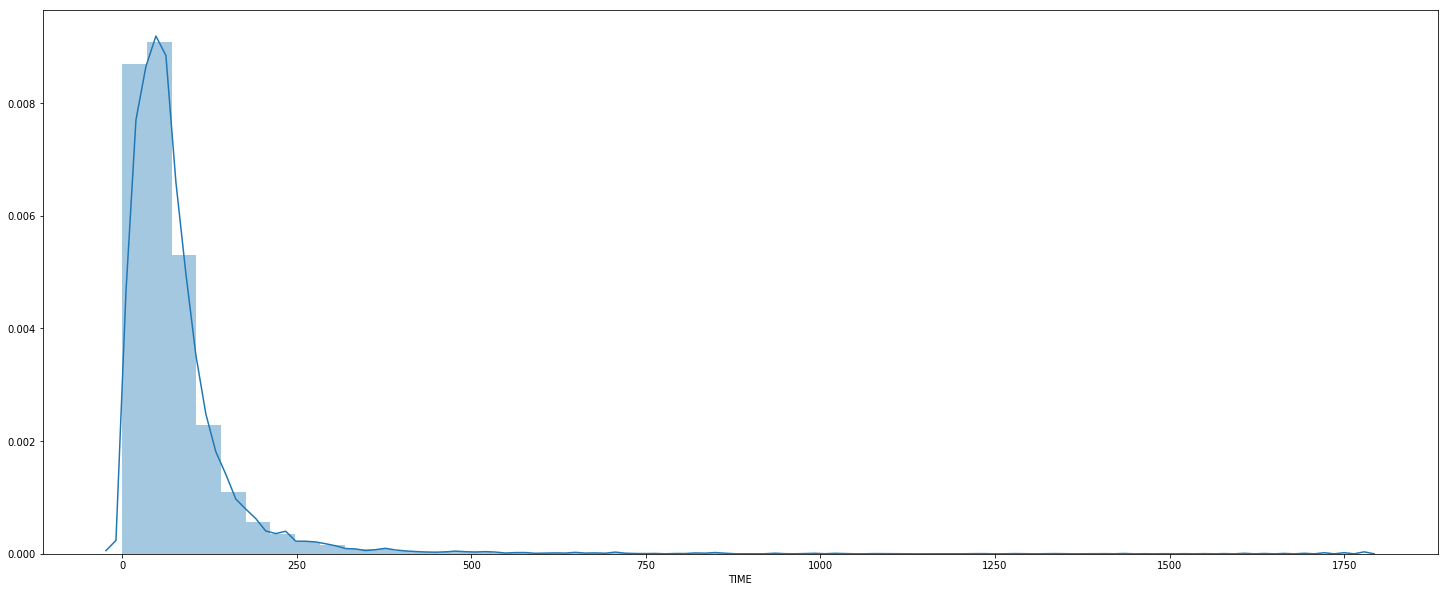

In [20]:
#Se grafica la distribución de TARGET
plt.rcParams['figure.figsize'] = [25, 10]

sns.distplot((df_ini[df_ini['ESTIMAR'] == 0].TARGET).values)
plt.xlabel('TIME')
plt.show()

Probada la asimetría de la distribución, su larga cola hacia la derecha y la lógica acumulación de valores en torno a 0, se procede a aplicar el logaritmo de (target+1) sobre la variable para corregir esta asimetría.

La elección de esta transformación logarítmica se basa en su efectividad al regularizar valores elevados. La utilización del logaritmo de TARGET + 1 se entiende por el gran número de valores 0 para los que el logaritmo tiende asintóticamente a menos infinito.

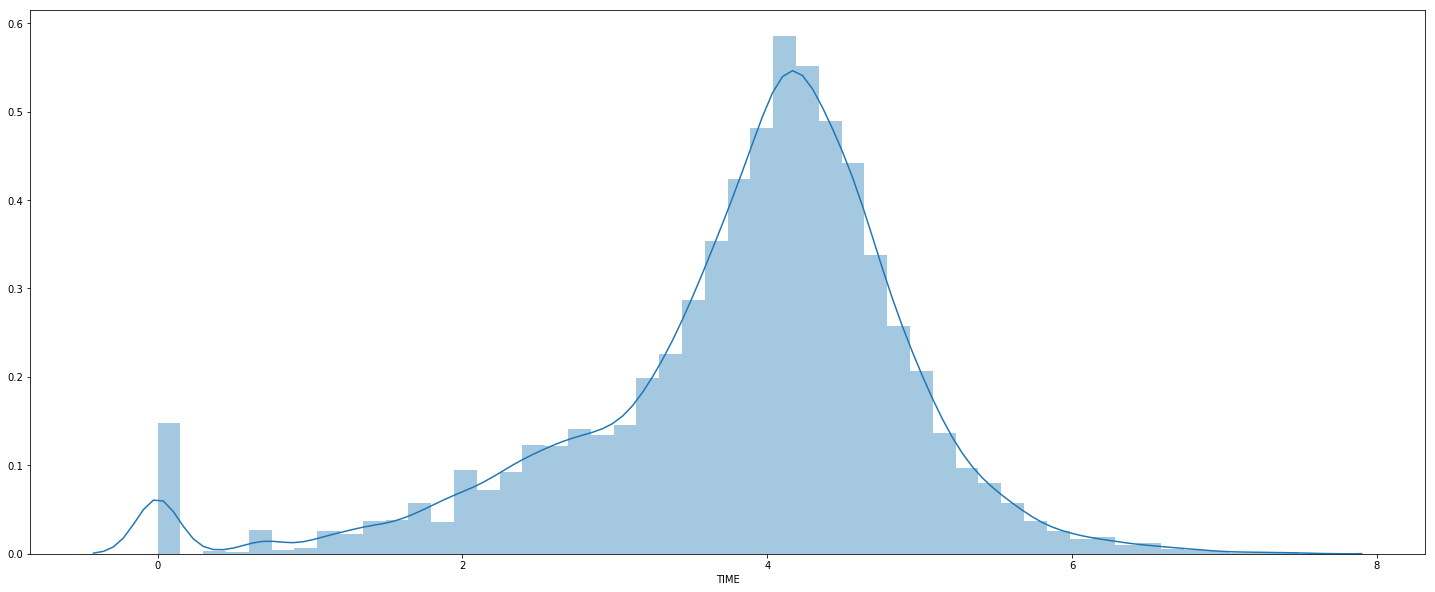

In [21]:
#Distribuión de TARGET aplicando transformación logarítmica
plt.rcParams['figure.figsize'] = [25, 10]

sns.distplot(np.log1p(df_ini[df_ini['ESTIMAR'] == 0].TARGET).values)
plt.xlabel('TIME')
plt.show()

Resulta evidente la normalización de la distribución que implicará una mejora del modelo. Para cuantificar la normalización, se vuelven a calcular los estimadores de asimetría de la distribución y se aplica definitivamente el logaritmo a TARGET.

In [22]:
#Se aplica definitivamente la transformación para todo el dataset
df_ini['TARGET']=np.log1p(df_ini.TARGET)

In [23]:
#Se comprueba que efectivamente los indicadores de cola y asimetría mejoran
print("Skewness: %f" % df_ini[df_ini['ESTIMAR'] == 0].TARGET.skew(),"Kurtosis: %f" % df_ini[df_ini['ESTIMAR'] == 0].TARGET.kurt())

Skewness: -1.099007 Kurtosis: 2.111987


Tanto la Kurtosis como el Skewness se han reducido drásticamente presentando valores de desviación de la media aceptables. 

Alternativamente a la normalización logarítmica, se ha trabajado con una transformación de tipo Box-Cox optimizada para el problema, sin embargo, sus resultados han sido ligeramente peores (décimas de diferencia) a los obtenidos por la transformación logarítmica.

### 2.5.2 TARGET Anómalo

Del análisis del TARGET y posterior normalización se han desprendido conclusiones acerca de la normalidad de la distribución y su idoneidad para el modelo. Sin embargo, existe un detalle una gran acumulación de valores en torno a 0 que requiere de un estudio en profundidad.

En primer lugar, cabe señalar que estos valores carecen de sentido físico ya que las visitas de 0 segundos son, por definición, anómalas. Por ello, se inspecciona visualmente la variable TARGET para tratar de identificar patrones en estos valores.

In [24]:
#Combinación parámetros 1. TARGET = 0 si se cumple
df_ini.loc[:,"GA_page_views":"TARGET"][df_ini["GA_page_views"]==0]

,GA_page_views,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET
290,0,0.0,0.0,4,4,0.000000
1064,0,0.0,0.0,4,4,0.000000
1911,0,0.0,0.0,4,4,0.000000
4510,0,0.0,0.0,4,4,0.000000
7816,0,0.0,0.0,4,4,0.000000
7819,0,0.0,0.0,4,4,0.000000
7820,0,0.0,0.0,4,4,0.000000
7821,0,0.0,0.0,4,4,0.000000
10630,0,0.0,0.0,4,4,25.328436


In [25]:
#Combinación parámetros 2. TARGET = 0 si se cumple
df_ini.loc[:,"GA_page_views":"TARGET"][df_ini["GA_exit_rate"]==100]

,GA_page_views,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET
234,1,0.00,100.0,26,26,0.000000
391,1,0.00,100.0,32,32,0.000000
530,1,100.00,100.0,36,36,0.000000
654,2,100.00,100.0,44,44,0.000000
879,2,50.00,100.0,21,33,0.000000
982,2,100.00,100.0,21,46,0.000000
1004,3,0.00,100.0,8,43,0.000000
1095,1,100.00,100.0,37,37,0.000000
1096,1,0.00,100.0,9,9,0.000000
1098,1,0.00,100.0,45,45,0.000000


Resulta evidente que cuando las visitas a la página son 0, o que cuando la tasa de salida es del 100 %, el valor de TARGET siempre es 0. Los valores observados como 25.32 se corresponden con los valores dummy de los registros a estimar, los cuales se predecirán automáticamente como 0.

In [26]:
#Se crea un dataframe que contenga los registros identificados como ceros para añadirlos posteriormente al modelado
df_zeros = pd.concat([df_ini[df_ini["GA_page_views"]==0],df_ini[df_ini["GA_exit_rate"]==100]])
df_zeros["TARGET"]=0
df_zeros = df_zeros.loc[:,["HY_id","TARGET","ESTIMAR"]]

Con estos criterios, se han identificado un total de 29 valores del dataset a estimar cuyos valores serán 0 y se podrán excluir de la predicción. Asimismo, los valores 0 del dataset a modelizar podrán ser excluidos del entrenamiento del modelo.

## 2.5 Feature Correlation

Con el objetivo de evaluar la validez de las features disponibles, sobre todo de aquellas creadas en el proceso de Feature Engineering, se procede a analizar las correlaciones de cada una con la variable TARGET y eliminar aquellas que no aporten información, es decir, cuya correlación sea nula.

In [27]:
corr_df = df_ini.corr()
lista_drop=list(corr_df.TARGET[pd.isnull(corr_df.TARGET)].index)
df_ini.drop(lista_drop, axis=1, inplace=True)
print(lista_drop)

['INMOBILIARIA', 'CASA RUSTICA', 'MASCOTAS', 'MASCOTA', 'ALQUILER VACACIONAL', 'HIPOTECA', 'MODERNODIST', 'HOSPITALDIST', 'COLEGIOSDIST', 'AFUERASDIST', 'PARQUESDIST', 'BUSDIST', 'PROFESIONALDIST', 'INMOBILIARIADIST', 'CASA RUSTICADIST', 'MASCOTASDIST', 'MASCOTADIST', 'ALQUILER VACACIONALDIST', 'COMPRADIST', 'HIPOTECADIST', 'CENTRO SALUDDIST']


# 3. Modelización
En este apartado se preparan los datos para su entrenamiento y evaluación. Posteriormente se seleccionará el modelo óptimo para el problema. Finalmente se entrenará el modelo y se ejecutará sobre el dataset a estimar.

## 3.1 Preparación de Datos

Se procede a preparar los datasets de modelado para su introducción al modelo. De esta forma se separarán definitivamente los sets de modelización y predicción. Dado que el modelo finalmente empleado trabaja con todo el dataset de modelización mediante cross-validation, no resulta necesario separar en sets de entrenamiento y validación, sin enmbargo, esta separación ha sido utilizada ampliamente en el proceso previo a alcanzar este modelo.

Como resultado de todas las iteraciones realizadas en los distintos modelos se optimizó el dataset utilizado para el entrenamiento filtrando las observaciones con valores de TARGET superiores al percentil 0.766. Este proceso se explica detalladamente en el ANEXO I.

Por otro lado, se han eliminado los registros con TARGET = 0, como se ha explicado previamente, para ser posteriormente añadidos al resultado final.

In [28]:
#Se separan los datasets y se guardan las IDs a estimar para la entrega final
df_modelling = df_ini[df_ini.ESTIMAR == 0]
df_estimar = df_ini[df_ini.ESTIMAR == 1]

#Se identifican y separan aquellos registros anómalos detectados como 0
df_ids = df_estimar[(df_estimar["GA_page_views"]==0) | (df_estimar["GA_exit_rate"]==100)]
ids_est_cero = list(df_ids.HY_id)

#Se elimina la meta-información de los datasets a tratar
df_modelling.drop(['ESTIMAR','HY_id'], axis=1, inplace=True)
ids_entrega = df_estimar.HY_id
df_estimar.drop(['ESTIMAR','TARGET','HY_id'], axis=1, inplace=True)

df_modelling_2 = df_modelling[(df_modelling.TARGET < df_modelling.TARGET.quantile(.766))& (df_modelling.TARGET>0)].copy()

y =df_modelling_2.TARGET.values

X = df_modelling_2.loc[:, df_modelling_2.columns != 'TARGET'].values

In [29]:
#Se obtienen los splits de entrenamiento y test
train, test = train_test_split(df_modelling, test_size=0.2,random_state=42)

In [30]:
#Se crea una función para evaluar el Median Absolute Error deshaciendo la transformación logarítmica
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae=median_absolute_error(np.expm1(test_labels), np.expm1(predictions))
  
    return mae

def evaluate_cv(y_pred, y_real):
    mae=median_absolute_error(np.expm1(y_real), np.expm1(y_pred))
    return mae

## 3.2 Definición de Modelo

Este apartado a concentrado gran parte de los esfuerzos de este proyecto, sobre todo en la última semana. Este trabajo queda reflejado en el ANEXO I donde se explica cada una de las aproximaciones empleadas a lo largo del proyecto y el proceso hasta alcanzar el modelo de stacking definido a continuación.

In [31]:
#STACKING

#El regresor requiere definir un random seed para forzar su comportamiento determinista debido a su implementación interna de CV
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

rf=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=False, random_state=42, verbose=False, warm_start=False)


GB=GradientBoostingRegressor(alpha=0.4, criterion='mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=15,
             max_features='auto', max_leaf_nodes=100,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=20, min_samples_split=50,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort=False, random_state=42,
             subsample=1.0, verbose=False,
             warm_start=False)


ext = ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=100,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=4, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=-1,
          oob_score=False, random_state=42, verbose=False, warm_start=False)


svr = SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
      kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

stack = StackingCVRegressor(regressors=(rf, GB, ext), meta_regressor=svr,refit=True)

## 3.3 Entrenamiento y Validación

Para evaluar la validez del modelo de stacking escogido se ha utilizado un modelo de cross-validation aplicado al stacking que permitirá evaluar su poder de predicción y generalización. Cabe destacar que el MAE obtenido en esta ejecución será sensiblemente inferior a la real debido a que se han retirado de dataset los registros por encima del percentil 0.766 tal y como se ha explicado en 3.1.

In [32]:
stack = StackingCVRegressor(regressors=(rf, GB, ext),meta_regressor=svr,refit=True)

y_pred = cross_val_predict(stack, X, y, cv=5)

mae = evaluate_cv(y_pred,y)

print(mae)

12.295259362051056


# 4. Predicción y entrega

Obtenido el mejor valor de evaluación mediante el stacking, se procede al entrenamiento y predicción del dataset completo para su entrega.

In [33]:
#Con el objetivo de coseguir una mejor generalización del modelo, se procede a entrenar el dataset completo

stack.fit(X, y)

StackingCVRegressor(cv=5,
          meta_regressor=SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          refit=True,
          regressors=(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estim..., n_jobs=-1,
          oob_score=False, random_state=42, verbose=False,
          warm_start=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=False)

In [34]:
#Finalmente se aplica el modelo para predecir los datos a estimar y se deshace la transformación logarítmica del TARGET

ent=stack.predict(df_estimar)
ent=np.expm1(ent)

In [35]:
#Se agregan los resultados a un DataFrame para su entrega
entregar=pd.DataFrame(list(map(list, zip(*[ids_entrega,ent]))),columns=['HY_id','TM_Est'])

In [36]:
#Notar que no existen valores TARGET = 0
entregar[entregar.TM_Est == 0].shape

(0, 2)

In [37]:
#Coherentemente con la identificación de valores 0, agregamos estos al resultado
entregar['TM_Est']=np.where(entregar.HY_id.isin(ids_est_cero),0,entregar.TM_Est)

In [38]:
#En total se han identificado 29 registros con TARGET = 0
entregar[entregar.TM_Est == 0].shape

(29, 2)

In [39]:
#Ahora si, se genera el documento final de entrega de resultados
entregar.to_csv('FRP learning.txt',sep='|',encoding='utf8',index=False)

# ANEXO I. OPTIMIZACIÓN

## AI.1 Búsqueda de parámetros y modelos óptimos
En el tiempo transcurrido desde el planteamiento de este problema, se ha descubierto que no es, ni mucho menos, trivial. Por este motivo se han probado multitud de regresores provistos por SciKit Learn y Keras (TensorFlow background). Además de la prueba de los modelos con parámetros por defecto, se ha intentado ajustar los parámetros internos con los métodos que de optimización. Al principio se optó por utilizar GridSearchCV, pero los tiempos de computación eran excesivamente largos y no resultaba posible en el plazo existente. Por ello se decidió finalmente por el uso de RandomizedSearchCV, que es menos exacto, pero mucho más veloz.


A continuación, se expresan todas las pruebas realizadas con diferentes algoritmos. Los códigos a continuación han sido utilizados de forma discrecional según se iban evaluando las necesidades.

### DEFINICIONES
#### GridSearchCV
Búsqueda de parámetros exhaustiva para un estimador. Se ajustan mediante una cuadrícula de valores, que va probando. Puede ser muy costoso computacionalmente. Por dentro usa además cross-validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### RandomizedSearchCV
A diferencia del gridsearhcv, no se prueban todos los valores de los parámetros, si no que se muestra un número fijo de configuraciones. Mucho más rápido para pruebas.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

#### Stacking
Es una forma de agrupar varios modelos de regresión o clasificación. En nuestro caso serían de regresión. Es una buena forma de crear un modelo más preciso y consistente.

http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/

http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/

### XGBOOST

Librería de gradient boosting con gran eficiencia. Esta implementado bajo el framework de Gradient Boosting. Este algoritmo es muy usado en problemas de regresión en kaggle.

https://xgboost.readthedocs.io/en/latest/

In [ ]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae=median_absolute_error(np.expm1(test_labels), np.expm1(predictions))
  
    return mae

train2 = train[(train.TARGET < train.TARGET.quantile(.8))& (train.TARGET>0)].copy()
train_x=train2.loc[:, train.columns != 'TARGET']
train_y=train2.TARGET
test = test[test.TARGET>0].copy()
test_x=test.loc[:, train.columns != 'TARGET']
test_y=test.TARGET

xgb1 = xgboost.XGBRegressor()
parameters = {'nthread':[4,6,10,20], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.03, 0.05, 0.07], #so called `eta` value
              'max_depth': [5, 6, 7,100,10,50],
              'min_child_weight': [4,10,100,200],
              'verbosity': [1],
              'subsample': [0.7,0.3,0.5,0.9,0.1,1],
              'colsample_bytree': [0.7],
              'n_estimators': [500,100,200,300]}

xgb_grid = RandomizedSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 7,
                        verbose=2)

xgb_grid.fit(train_x,
         train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

### RandomForestRegressor

Se basa en la realización de árboles aleatorios. Se generan n áboles de decisión con varias submuestras de datos y se utiliza el promedio para ajustar la predicción, además de evitar el overffiting.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae=median_absolute_error(np.expm1(test_labels), np.expm1(predictions))
  
    return mae

train2 = train[(train.TARGET < train.TARGET.quantile(.8))& (train.TARGET>0)].copy()
train_x=train2.loc[:, train.columns != 'TARGET']
train_y=train2.TARGET
test = test[test.TARGET>0].copy()
test_x=test.loc[:, train.columns != 'TARGET']
test_y=test.TARGET

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_grid = RandomizedSearchCV(rf,
                        random_grid,
                        cv = 5,
                        n_jobs = 7,
                        verbose=2)

rf_grid.fit(train_x,
         train_y)

print(rf_grid.best_score_)
print(rf_grid.best_params_)

In [ ]:
def Grid_Search_CV_RFR(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.ensemble import RandomForestRegressor

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [300,400,500],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [8,10,15],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_,grid



train2 = train[(train.TARGET < train.TARGET.quantile(.8))& (train.TARGET>0)].copy()
train_x=train2.loc[:, train.columns != 'TARGET']
train_y=train2.TARGET
test = test[test.TARGET>0].copy()
test_x=test.loc[:, train.columns != 'TARGET']
test_y=test.TARGET


x,y,z=Grid_Search_CV_RFR (train_x,train_y)

### AdaBoostRegressor

Este tipo de regresor empieza ajustando el conjunto de datos original, para pasar más tarde a ajustar diferentes instancias de acuerdo con el error de predicción obtenido.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }

pre_gs_inst = RandomizedSearchCV(AdaBoostRegressor(),
 param_distributions = param_dist,
 cv=3,
 n_iter = 10,
 n_jobs=-1)

train2 = train[(train.TARGET < train.TARGET.quantile(.8))& (train.TARGET>0)].copy()
train_x=train2.loc[:, train.columns != 'TARGET']
train_y=train2.TARGET
test = test[test.TARGET>0].copy()
test_x=test.loc[:, train.columns != 'TARGET']
test_y=test.TARGET

pre_gs_inst.fit(train_x, train_y)

### Epsilon-Support Vector Regression (SVR)

Intentan separar conjuntos de datos con hiperplanos para lograr la predicción.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [ ]:
from sklearn.svm import SVR
import numpy as np
from sklearn.model_selection import GridSearchCV

train2 = train[(train.TARGET < train.TARGET.quantile(.8))& (train.TARGET>0)].copy()
train_x=train2.loc[:, train.columns != 'TARGET']
train_y=train2.TARGET
test = test[test.TARGET>0].copy()
test_x=test.loc[:, train.columns != 'TARGET']
test_y=test.TARGET

parameters = {'kernel': ['rbf'], 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
svr = SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(train_x,train_y)
clf.best_estimator_

### Redes Neuronales (Sequential Model)

Conjunto de unidades conectadas entre sí para transmitir señales. La información de entrada atraviesa la red produciendo ciertos valores de salida.

https://es.wikipedia.org/wiki/Red_neuronal_artificial
https://keras.io/models/sequential/

In [ ]:
import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential

# Initialising the ANN
model = Sequential()
model.add(Dense(12, input_dim=183, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

#model.add(Dense(1))
# Compiling the ANN
model.compile(loss='mae', optimizer='adam', metrics=['mse','mae'])

train2 = train[(train.TARGET < train.TARGET.quantile(.80))& (train.TARGET>0)].copy()
train_x=train2.loc[:, train.columns != 'TARGET']
train_y=train2.TARGET
test = test[test.TARGET>0].copy()
test_x=test.loc[:, train.columns != 'TARGET']
test_y=test.TARGET
# Fitting the ANN to the Training set
model.fit(train_x, train_y, batch_size = 1, epochs = 10)

random_mae = evaluate(model, test_x, test_y)
print(random_mae)

zero = df_zeros["TARGET"][df_zeros["ESTIMAR"]==0]
test_0 = zero.values[:int(0.2*len(zero))]
predictions = model.predict(test_x)
print(median_absolute_error(np.concatenate((np.expm1(test_y),test_0),axis=None), np.concatenate((np.expm1(predictions),test_0),axis=None)))

## AI.2 Busqueda de Percentil Óptimo
Tras los distintos análisis exploratorios se detecta un considerable número de valores elevados que perjudican considerablemente al modelo. Con el objetivo de reducir el ruido y logar una mejor predicción sobre los valores normales, se opta por entrenar separando un percentil superior del dataset. Para seleccionar el percentil a separar del dataset se ha implementado un cross-validation manual que itera los distintos percentiles y almacena los resultados.

In [ ]:
#Cross_val_manual_stack
crosses = [0,0.2,0.4,0.6,0.8,1]
crosses = (np.array(crosses)*df_modelling.shape[0]).round().astype("int")
df_modelling.sample(frac=1,random_state=42)

perc_l=[]
mae_l=[]
mae0_l=[]

for j in np.arange(0.7,0.95,0.001):
    mae_i = []
    mae_i0 = []
    for i in range(1,6):
        train = pd.concat([df_modelling.iloc[crosses[i]:crosses[5],:],df_modelling.iloc[crosses[0]:crosses[i-1],:]])
        test = df_modelling.iloc[crosses[i-1]:crosses[i],:]

        RANDOM_SEED = 42

        rf=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                   max_features='auto', max_leaf_nodes=None,
                   min_impurity_decrease=0.0, min_impurity_split=None,
                   min_samples_leaf=4, min_samples_split=10,
                   min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
                   oob_score=False, random_state=42, verbose=False, warm_start=False)


        GB=GradientBoostingRegressor(alpha=0.4, criterion='mse', init=None,
                     learning_rate=0.05, loss='huber', max_depth=15,
                     max_features='auto', max_leaf_nodes=100,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=20, min_samples_split=50,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     presort=False, random_state=42,
                     subsample=1.0, verbose=False,
                     warm_start=False)


        ext = ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=100,
                  max_features='auto', max_leaf_nodes=None,
                  min_impurity_decrease=0.0, min_impurity_split=None,
                  min_samples_leaf=4, min_samples_split=2,
                  min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=-1,
                  oob_score=False, random_state=42, verbose=False, warm_start=False)

        svr_rbf = SVR(kernel='rbf')

        # The StackingCVRegressor uses scikit-learn's check_cv
        # internally, which doesn't support a random seed. Thus
        # NumPy's random seed need to be specified explicitely for
        # deterministic behavior

        np.random.seed(RANDOM_SEED)
        stack = StackingRegressor(regressors=[GB,rf,ext],refit=True, 
                                   meta_regressor=SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
          kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))

        train2 = train[(train.TARGET < train.TARGET.quantile(j))& (train.TARGET>0)].copy()
        train_x=train2.loc[:, train.columns != 'TARGET']
        train_y=train2.TARGET
        test = test[test.TARGET>0].copy()
        test_x=test.loc[:, train.columns != 'TARGET']
        test_y=test.TARGET


        stack.fit(train_x, train_y)
        predictions = stack.predict(test_x)
        mae=median_absolute_error(np.expm1(test_y), np.expm1(predictions))
        #random_mae = evaluate(stack, test_x, test_y)
        #print(mae)

        zero = df_zeros["TARGET"][df_zeros["ESTIMAR"]==0]
        test_0 = zero.values[:int(0.2*len(zero))]
        predictions = stack.predict(test_x)
        mae_0 = median_absolute_error(np.concatenate((np.expm1(test_y),test_0),axis=None), np.concatenate((np.expm1(predictions),test_0),axis=None))
        
    print(j,np.mean(mae),np.mean(mae_0))
    perc_l.append(j)
    mae_l.append(np.mean(mae))
    mae0_l.append(np.mean(mae_0))

Tras ejecutar la iteración completa se obtiene el mejor resultado de MAE de forma consistente en el percentil 0.766.

## AI.3 Natural Languaje Processing (NLP)
Como se ha comentado en el cuerpo del proyecto, con el objetivo de realizar un análisis detallado de los features de texto abierto, se ha empleado un procedimiento sistemático de clasificación y selección de palabras clave mediante "bag of words". Los resultados del "bag of words" se han correlacionado con la variabe TARGET para obtener aquellas palabras clave más relevantes. Posteriormente, se han combinado estas palabras con las recomendaciones establecidas en la web enlazada de idealista comprendiendo el significado que tienen para los usuarios del portal.

https://www.idealista.com/news/inmobiliario/vivienda/2017/11/24/749048-consejos-practicos-para-conseguir-una-buena-descripcion-de-los-inmuebles

Todo esto ha resultado en el mejor modelo de análisis NLP.

In [ ]:
stop_words = get_stop_words('spanish')
TOKENS_BASIC = r"[A-Za-z]+(?=\s+|[.]|[()])"
vectorizer = CountVectorizer(token_pattern=TOKENS_BASIC,stop_words=stop_words,ngram_range=(1,2))
df_ta_cv = vectorizer.fit_transform(df_weird["HY_descripcion"])
df_text = pd.DataFrame(df_ta_cv.toarray(),columns=vectorizer.get_feature_names())
f5t = df_text.sum().sort_values(ascending=False).index[:5000]
chi_k = 100
skb = SelectKBest(chi2, chi_k)
df_ta_cv = skb.fit_transform(df_text[f5t].values,df_weird["TARGET"].astype("int64"))
df_text[f5t].loc[:,skb.get_support()].columns